In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [8]:
#CLEAN, PREPARE, AND MERGE DATA

demand_data = pd.read_csv('demand.csv')
prices_data = pd.read_csv('prices.csv')
households_data = pd.read_csv('households.csv')
temp_data = pd.read_csv('Temperaturer.csv', sep=';')
covid_data = pd.read_csv('OxCGRT_timeseries_GovernmentResponseIndex_v1.csv')

norway_data = covid_data[covid_data['CountryName'] == 'Norway']

norway_data = norway_data.dropna(axis=1)

norway_covid = norway_data.melt(
    id_vars=['CountryCode', 'CountryName', 'Jurisdiction'],
    var_name='Date_str',
    value_name='GovernmentResponseIndex'
)

# Convert the date string to datetime format
norway_covid['Date'] = pd.to_datetime(norway_covid['Date_str'], format='%d%b%Y')
norway_covid = norway_covid[['Date', 'GovernmentResponseIndex']]


print("\n=== Initial Data Shapes ===")
print(f"Demand data shape: {demand_data.shape}")
print(f"Prices data shape: {prices_data.shape}")
print(f"Households data shape: {households_data.shape}")
print(f"Temperature data shape: {temp_data.shape}")


# Clean column names and data
temp_data.columns = ['City', 'Timestamp_UTC', 'Temperature', 'Temperature24', 'Temperature48', 'Temperature72']

# Convert timestamp to datetime
temp_data['Timestamp_UTC'] = pd.to_datetime(temp_data['Timestamp_UTC'])

# Convert temperature to numeric, replacing , with .
temp_data['Temperature24'] = temp_data['Temperature24'].str.replace(',', '.').astype(float)

# Create Date and Hour columns to match with demand data
temp_data['Date'] = pd.to_datetime(temp_data['Timestamp_UTC'].dt.date)
temp_data['Hour'] = temp_data['Timestamp_UTC'].dt.hour


city_to_area = {
    'Oslo': 'NO1',
    'Sarpsborg': 'NO1',
    'Moss': 'NO1',
    'Bergen': 'NO5'
}

temp_data['Price_area'] = temp_data['City'].map(city_to_area)
temp_data = temp_data[['Date', 'Hour', 'Price_area', 'Temperature24']]

#Prepare temp_data for merging, avoiding duplicates
temp_data = temp_data.groupby(['Price_area', 'Date', 'Hour'], as_index=False)['Temperature24'].mean()

print("\n=== Temperature data after grouping ===")
print(f"Shape of unique temperature data: {temp_data.shape}")


#1Merge demand_data and households_data
merged_data = pd.merge(demand_data, households_data[['ID', 'Price_area']], on='ID', how='left')
print("\n=== After first merge ===")
print(f"Shape after merging with households: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

#2Merge merged_data and prices_data
merged_data = pd.merge(merged_data, prices_data[['Price_area', 'Date', 'Hour', 'Price_NOK_MWh', 'Price_NOK_kWh']],
                      on=['Price_area', 'Date', 'Hour'], how='left')
print("\n=== After second merge ===")
print(f"Shape after merging with prices: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

merged_data['Date'] = pd.to_datetime(merged_data['Date']) #needed

#3Final merge of merged_data and temp_data
merged_data = pd.merge(merged_data, temp_data,
                      on=['Price_area', 'Date', 'Hour'],
                      how='left')

print("\n=== After third merge ===")
print(f"Shape after merging with temperature: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

#4Final merge of merged_data and norway_covid
merged_data = pd.merge(
    merged_data,
    norway_covid,
    on='Date',
    how='left'
)

print("\n=== After COVID data merge ===")
print(f"Shape after merging with COVID data: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")




=== Initial Data Shapes ===
Demand data shape: (14913408, 4)
Prices data shape: (135240, 5)
Households data shape: (4446, 5)
Temperature data shape: (1115472, 6)

=== Temperature data after grouping ===
Shape of unique temperature data: (248208, 4)

=== After first merge ===
Shape after merging with households: (14913408, 5)
Number of duplicate rows after merge: 0

=== After second merge ===
Shape after merging with prices: (14913408, 7)
Number of duplicate rows after merge: 0

=== After third merge ===
Shape after merging with temperature: (14913408, 8)
Number of duplicate rows after merge: 0

=== After COVID data merge ===
Shape after merging with COVID data: (14913408, 9)
Number of duplicate rows after merge: 0


In [9]:
#REGRESSION MODEL

# Create the Day_of_week and Hour_of_day columns
merged_data['Day_of_week'] = merged_data['Date'].dt.dayofweek
merged_data['Hour_of_day'] = merged_data['Hour']

price_responses = []

grouped = merged_data.groupby('ID')

for household_id, group in grouped:
    # Create feature matrix and target variable
    X = group[['Price_NOK_kWh', 'Temperature24', 'Hour_of_day', 'Day_of_week']] # use average temperature, covid data, maybe add hour of the week
    y = group['Demand_kWh']
    
    # Remove rows with missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    X = sm.add_constant(X)
    
    try:
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        
        # Extract the coefficients
        price_response = model.params['Price_NOK_kWh']
        temp_response = model.params['Temperature24']
        
        # Compute price elasticity
        avg_price = group['Price_NOK_kWh'].mean()
        avg_demand = group['Demand_kWh'].mean()
    
        if avg_demand > 0:  # Avoid division by zero
            price_elasticity = (price_response * avg_price) / avg_demand
        else:
            price_elasticity = None  # Handle edge cases where demand is 0
        
        # Store the results
        price_responses.append({
            'ID': household_id,
            'Price_Response': price_response,
            'Temperature_Response': temp_response,
            'N_Observations': len(X),
            'R_squared': model.rsquared,
            'Price_elasticity': price_elasticity
        })
        
    except Exception as e:
        print(f"Error processing household {household_id}: {str(e)}")
        continue

results_df = pd.DataFrame(price_responses)

# Display summary statistics of the results
print("\n=== Summary Statistics of Results ===")
print(results_df.describe())

# Calculate and print the percentage of households with positive price response
pos_price_response = (results_df['Price_Response'] > 0).mean() * 100
print(f"\nPercentage of households with positive price response: {pos_price_response:.2f}%")

#Temperature response statistics
print("\n=== Temperature Response Statistics ===")
print(results_df['Temperature_Response'].describe())

#Final DataFrame
print("\n=== Final Results ===")
print(results_df.head())

#Price elasticity
print(results_df['Price_elasticity'])




=== Summary Statistics of Results ===
                ID  Price_Response  Temperature_Response  N_Observations  \
count  1136.000000     1136.000000           1136.000000          1136.0   
mean   3603.722711       -0.121670             -0.072003         12581.0   
std    2330.846242        0.220408              0.061308             0.0   
min      18.000000       -1.317351             -0.330253         12581.0   
25%    1480.000000       -0.211212             -0.107179         12581.0   
50%    3405.500000       -0.076615             -0.058428         12581.0   
75%    5773.250000       -0.008578             -0.021079         12581.0   
max    8386.000000        1.670308              0.044759         12581.0   

         R_squared  Price_elasticity  
count  1136.000000       1136.000000  
mean      0.349735         -0.065891  
std       0.186665          0.125404  
min       0.007929         -0.824224  
25%       0.202176         -0.114677  
50%       0.332609         -0.056173  
75%

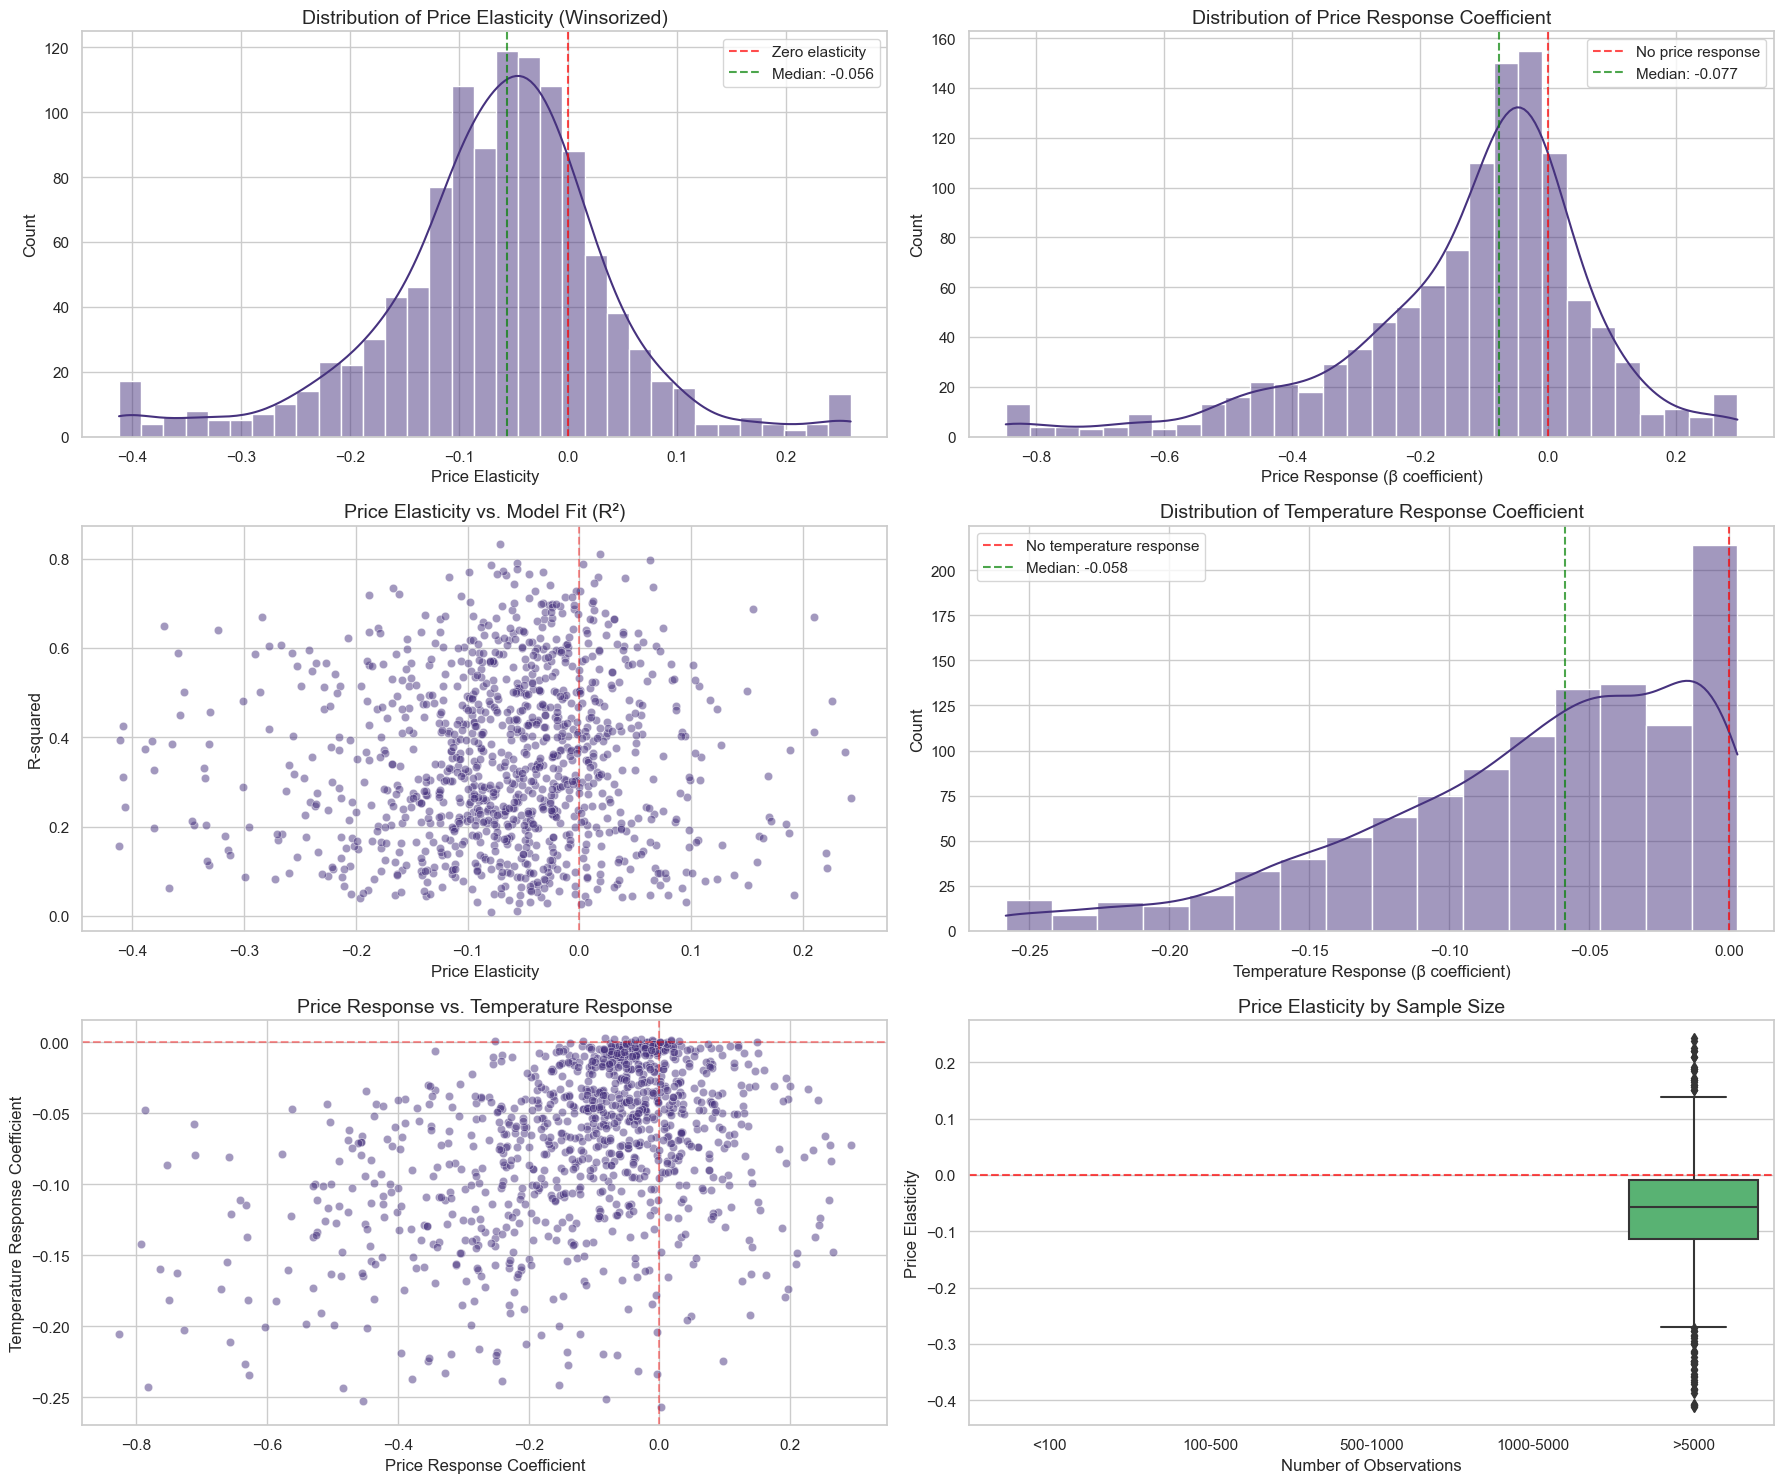

<Figure size 1000x800 with 0 Axes>

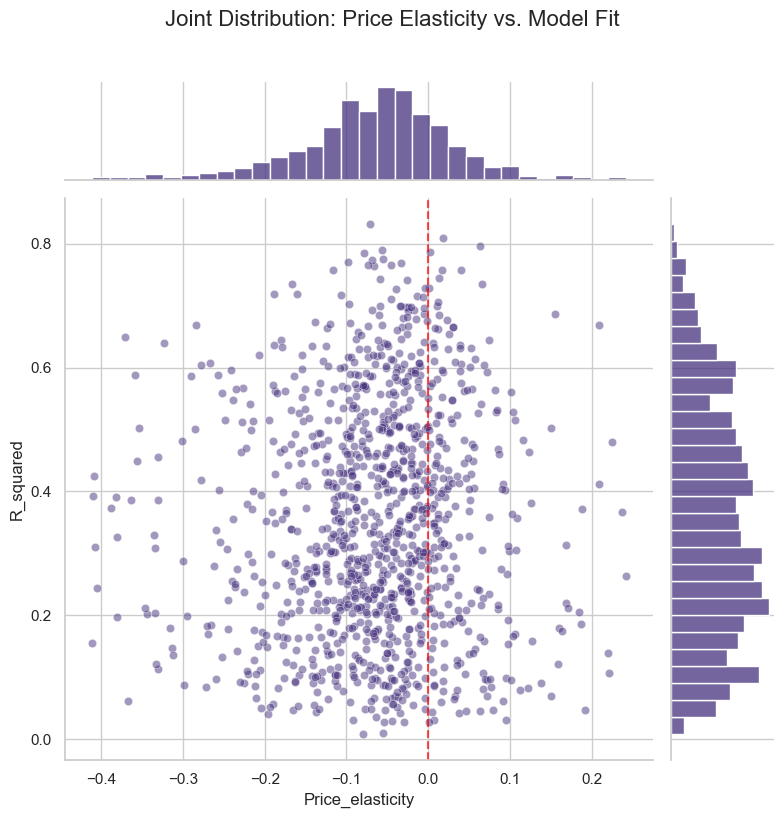

In [10]:
#PLOTS

# Use a more widely available style
plt.style.use('default')
sns.set_theme(style="whitegrid")  # Modern seaborn styling
sns.set_palette("viridis")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 15))

# 1. Distribution of Price Elasticity (with outlier handling)
ax1 = plt.subplot(3, 2, 1)
# Use winsorization to handle extreme outliers (clip at 1st and 99th percentiles)
elasticity_data = results_df['Price_elasticity'].copy()
lower_bound = np.percentile(elasticity_data.dropna(), 1)
upper_bound = np.percentile(elasticity_data.dropna(), 99)
elasticity_data_clean = elasticity_data.clip(lower_bound, upper_bound)

sns.histplot(elasticity_data_clean, kde=True, ax=ax1)
ax1.set_title('Distribution of Price Elasticity (Winsorized)', fontsize=14)
ax1.set_xlabel('Price Elasticity', fontsize=12)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero elasticity')
ax1.axvline(x=elasticity_data_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {elasticity_data_clean.median():.3f}')
ax1.legend()

# 2. Distribution of Price Response Coefficient
ax2 = plt.subplot(3, 2, 2)
# Again handling extreme outliers
price_response_data = results_df['Price_Response'].copy()
lower_bound_pr = np.percentile(price_response_data.dropna(), 1)
upper_bound_pr = np.percentile(price_response_data.dropna(), 99)
price_response_clean = price_response_data.clip(lower_bound_pr, upper_bound_pr)

sns.histplot(price_response_clean, kde=True, ax=ax2)
ax2.set_title('Distribution of Price Response Coefficient', fontsize=14)
ax2.set_xlabel('Price Response (β coefficient)', fontsize=12)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No price response')
ax2.axvline(x=price_response_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {price_response_clean.median():.3f}')
ax2.legend()

# 3. Price Elasticity vs. R-squared
ax3 = plt.subplot(3, 2, 3)
# Filter extreme values for better visualization
mask = (results_df['Price_elasticity'].between(lower_bound, upper_bound)) &        (results_df['R_squared'] <= 1.0)
sns.scatterplot(data=results_df[mask], x='Price_elasticity', y='R_squared', alpha=0.5, ax=ax3)
ax3.set_title('Price Elasticity vs. Model Fit (R²)', fontsize=14)
ax3.set_xlabel('Price Elasticity', fontsize=12)
ax3.set_ylabel('R-squared', fontsize=12)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.4)

# 4. Temperature Response Distribution
ax4 = plt.subplot(3, 2, 4)
# Handle outliers
temp_response_data = results_df['Temperature_Response'].copy()
lower_bound_temp = np.percentile(temp_response_data.dropna(), 1)
upper_bound_temp = np.percentile(temp_response_data.dropna(), 99)
temp_response_clean = temp_response_data.clip(lower_bound_temp, upper_bound_temp)

sns.histplot(temp_response_clean, kde=True, ax=ax4)
ax4.set_title('Distribution of Temperature Response Coefficient', fontsize=14)
ax4.set_xlabel('Temperature Response (β coefficient)', fontsize=12)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No temperature response')
ax4.axvline(x=temp_response_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {temp_response_clean.median():.3f}')
ax4.legend()

# 5. Price Response vs. Temperature Response
ax5 = plt.subplot(3, 2, 5)
# Filter for non-extreme values
mask = (results_df['Price_Response'].between(lower_bound_pr, upper_bound_pr)) &        (results_df['Temperature_Response'].between(lower_bound_temp, upper_bound_temp))
sns.scatterplot(data=results_df[mask], 
                x='Price_Response', 
                y='Temperature_Response', 
                alpha=0.5, 
                ax=ax5)
ax5.set_title('Price Response vs. Temperature Response', fontsize=14)
ax5.set_xlabel('Price Response Coefficient', fontsize=12)
ax5.set_ylabel('Temperature Response Coefficient', fontsize=12)
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.4)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.4)

# 6. Boxplot of elasticity by observation count category
ax6 = plt.subplot(3, 2, 6)
# Create categories of observation counts
results_df['Observation_Category'] = pd.cut(
    results_df['N_Observations'], 
    bins=[0, 100, 500, 1000, 5000, np.inf], 
    labels=['<100', '100-500', '500-1000', '1000-5000', '>5000']
)
# Filter extreme elasticity values
mask = results_df['Price_elasticity'].between(lower_bound, upper_bound)
sns.boxplot(data=results_df[mask], 
            x='Observation_Category', 
            y='Price_elasticity',
            ax=ax6)
ax6.set_title('Price Elasticity by Sample Size', fontsize=14)
ax6.set_xlabel('Number of Observations', fontsize=12)
ax6.set_ylabel('Price Elasticity', fontsize=12)
ax6.axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Additional bonus plot - Joint distribution of Price Elasticity and R-squared
plt.figure(figsize=(10, 8))
mask = (results_df['Price_elasticity'].between(lower_bound, upper_bound)) &        (results_df['R_squared'] <= 1.0)
g = sns.jointplot(
    data=results_df[mask],
    x='Price_elasticity', 
    y='R_squared',
    kind='scatter',
    height=8,
    marginal_kws=dict(bins=30, fill=True),
    joint_kws=dict(alpha=0.5)
)
g.fig.suptitle('Joint Distribution: Price Elasticity vs. Model Fit', y=1.02, fontsize=16)
g.ax_joint.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


   ID  Q_Age  Q_Gender  Q_City  Q1  Q4  Q7  Q13_1  Q13_2  Q13_3  ...  Q27_5  \
0  18     71         1       4   2   3   3      1      1      0  ...      0   
1  19     56         2       7   1   2   1      1      0      0  ...      0   
2  20     25         2       5   2   5   3      0      0      0  ...      0   
3  23     65         2       5   1   1   2      1      0      0  ...      0   
4  24     59         2       7   2   2   2      1      1      0  ...      1   

   Q27_6  Q27_7  Q27_8  Q27_9  Q27_10  Q28  Q29  Q32  Price_elasticity  
0      0      0      0      0       0    4    2    3         -0.221848  
1      0      1      0      0       0    4    2    2               NaN  
2      0      1      0      0       0    4    2    6               NaN  
3      0      0      0      0       0    1    2    1         -0.080356  
4      0      0      0      0       0    1    2    2               NaN  

[5 rows x 42 columns]
(4446, 42)
(1136, 42)


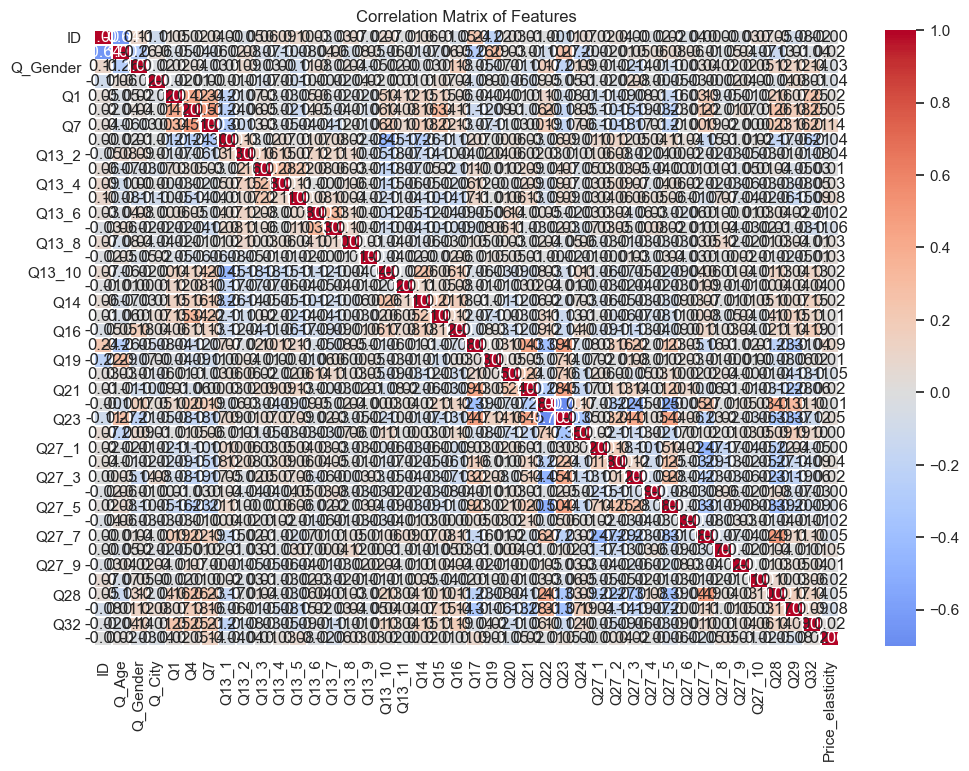

Top features correlated with Price_elasticity:
       Price_elasticity
Q7             0.140999
Q17            0.088964
Q29           -0.080753
Q13_5          0.075378
Q13_7         -0.063585
Q27_5         -0.058435
Q20           -0.051480
Q27_8          0.051096
Q23            0.050209
Q27_7         -0.049824


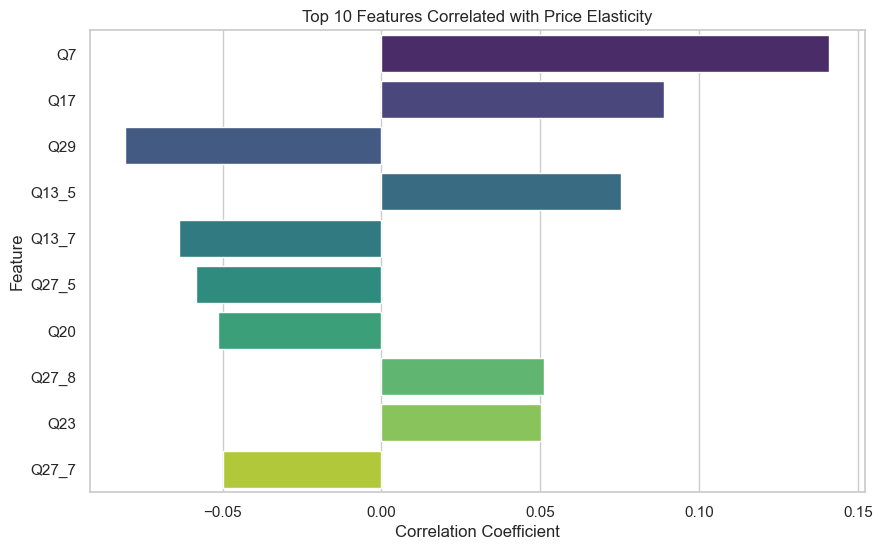

In [11]:
#PREPARE DATA FOR MACHINE LEARNING BY MAKING DATASET WITH SURVEY DATA AS THE FEATURES AND PRICE ELASTICITY AS THE TARGET

survey_data = pd.read_csv('answers.csv')
survey_data = survey_data.dropna(axis=1)

#add price elacticity to survey data
df_PE = results_df[['ID', 'Price_elasticity']]
df_survey_PE = pd.merge(survey_data, df_PE,
                      on=['ID'],
                      how='left')

print(df_survey_PE.head())
print(df_survey_PE.shape)

df_survey_PE = df_survey_PE.dropna(axis=0)
#save data as csv, to use for machine learning in different file named 'FeatureSelection'
df_survey_PE.to_csv('survey_PE1.csv', index=False) 

print(df_survey_PE.shape)

#CORRELATION MATRIX
corr_matrix = df_survey_PE.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Calculate correlations with Price_elasticity (sorted by absolute value)
corr_with_target = df_survey_PE.corr()[['Price_elasticity']].drop('Price_elasticity')
corr_with_target['abs_corr'] = corr_with_target['Price_elasticity'].abs()  # Absolute value for ranking
corr_with_target_sorted = corr_with_target.sort_values('abs_corr', ascending=False)

print("Top features correlated with Price_elasticity:")
print(corr_with_target_sorted.drop(columns=['abs_corr']).head(10))  # Show top 10

plt.figure(figsize=(10, 6))
sns.barplot(
    x=corr_with_target_sorted['Price_elasticity'].head(10), 
    y=corr_with_target_sorted.index[:10],
    palette='viridis'
)
plt.title("Top 10 Features Correlated with Price Elasticity")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()